# PV Power Production Forecast

### Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import holidays
import missingno as msno
import warnings
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from matplotlib.dates import DateFormatter, AutoDateLocator
from datetime import datetime
from datetime import timedelta

warnings.filterwarnings('ignore')

### Plot Parameters

In [2]:
plt.rcParams['figure.figsize']=(10,5)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
pd.set_option('display.max_columns', None)

### Auxiliary Functions

In [3]:
#Function define_season

"""
Gives the number of the season based on the month 
    
Args:
    month_number
        
Returns:
    1 - Winter
    2 - Spring
    3 - Summer
    4 - Fall
"""

def define_season(month_number):
    if month_number in [12,1,2]:
        return 1
    
    elif month_number in [3,4,5]:
        return 2
    
    elif month_number in [6,7,8]:
        return 3
    
    elif month_number in [9,10,11]:
        return 4

In [4]:
# Function create_features

"""
Creates date/time features from a dataframe 
    
Args:
    df - dataframe with a datetime index
        
Returns:
    df - dataframe with 'Weekofyear','Dayofyear','Month','Dayofmonth',
                        'Dayofweek','Weekend','Season','Holiday','Hour' and 'Minute' features created
"""

def create_features(df):
    
    df['Date'] = df.index
    df['Weekofyear'] = df['Date'].dt.weekofyear   #Value: 1-52
    df['Dayofyear'] = df['Date'].dt.dayofyear    #Value: 1-365
    df['Month'] = df['Date'].dt.month   #Value: 1-12
    df['Dayofmonth'] = df['Date'].dt.day   #Value: 1-30/31
    df['Dayofweek'] = df['Date'].dt.weekday+1     #Value: 1-7 (Monday-Sunday)
    df['Weekend'] = np.where((df['Dayofweek'] == 6) | (df['Dayofweek'] == 7), 1, 0)    #Value: 1 if weekend, 0 if not
    df['Season'] = df.Month.apply(define_season)    #Value 1-4 (winter, spring, summer and fall)
    df['Hour'] = df['Date'].dt.hour
    df['Hour'] = (df['Hour']+24).where(df['Hour'] == 0, df['Hour'])    #Value: 1-24
    df['Minute'] = df['Date'].dt.minute     #Value: 0, 15, 30 or 45
    df = df.drop(['Date'], axis=1)
    
    return df

In [5]:
# Function lag_features

"""
Creates lag features for the target variable
    
Args:
    lag_dataset - dataframe 
    days_list - list with the number of days to lag
    var - name of the column to lag (target variable)
        
Returns:
    lag_dataset - dataframe with lag features created
"""

def lag_features(lag_dataset, days_list, var):
    
    temp_data = lag_dataset[var]
    
    for days in days_list:
        rows = 96 * days
        lag_dataset[var + "_lag_{}".format(days)] = temp_data.shift(rows)

    return lag_dataset 

In [6]:
# Function cyclical_features

"""
Transforms (date/time) features into cyclical sine and cosine features
    
Args:
    df - dataframe with 'Weekofyear','Dayofyear','Season','Month',
                        'Dayofmonth','Dayofweek','Hour','Minute' columns
        
Returns:
    df - dataframe including the cyclical features (x and y for each column)
"""

def cyclical_features(df):

    df['Weekofyear_x']= np.cos(df['Weekofyear']*2*np.pi/52)
    df['Weekofyear_y']= np.sin(df['Weekofyear']*2*np.pi/52)
    df['Dayofyear_x']= np.cos(df['Dayofyear']*2*np.pi/365)
    df['Dayofyear_y']= np.sin(df['Dayofyear']*2*np.pi/365)
    df['Season_x']= np.cos(df['Season']*2*np.pi/4)
    df['Season_y']= np.sin(df['Season']*2*np.pi/4)
    df['Month_x']= np.cos(df['Month']*2*np.pi/12)
    df['Month_y']= np.sin(df['Month']*2*np.pi/12)
    df['Dayofmonth_x']= np.cos(df['Dayofmonth']*2*np.pi/31)
    df['Dayofmonth_y']= np.sin(df['Dayofmonth']*2*np.pi/31)
    df['Dayofweek_x']= np.cos(df['Dayofweek']*2*np.pi/7)
    df['Dayofweek_y']= np.sin(df['Dayofweek']*2*np.pi/7)
    df['Hour_x']= np.cos(df['Hour']*2*np.pi/24)
    df['Hour_y']= np.sin(df['Hour']*2*np.pi/24)
    df['Minute_x']= np.cos(df['Minute']*2*np.pi/45)
    df['Minute_y']= np.sin(df['Minute']*2*np.pi/45)
    
    df= df.drop(columns=['Weekofyear','Dayofyear','Season','Month','Dayofmonth',
                                         'Dayofweek','Hour','Minute'])
    
    return df

In [7]:
# Function compute_errors

"""
Calculates the metrics to measure the perfomance of the forecasting models
    
Args:
    df - dataframe with 'Prediction' and 'Real' columns
    val - value used to normalized 
        
Returns:
    MAE - mean absolute error
    RMSE - root mean square error
    normRMSE - normalized root mean square error
    R2 - coefficient of determination
"""

def compute_errors(df, val):

    MAE = metrics.mean_absolute_error(df.Real, df.Prediction)
    RMSE = np.sqrt(metrics.mean_squared_error(df.Real, df.Prediction))
    normRMSE = 100 * RMSE / val
    R2 = metrics.r2_score(df.Real, df.Prediction)
    
    return MAE, RMSE, normRMSE, R2

In [8]:
# Function result_plots

"""
Creates the plots to compare the real values with the predictions obtained
    
Args:
    df - dataframe with 'Prediction' and 'Real' columns
    model_name - string with the name of the model that will appear in the title of the plots
        
Returns:
    Two plots showed
"""

def result_plots(df, model_name):

    # Regression Plot
    sns.scatterplot(data= df, x= 'Real', y= 'Prediction')
    plt.plot(df.Real, df.Real, color = "dodgerblue", linewidth= 1) 
    plt.xlabel("Real Power (W)", alpha= 0.75, weight= "bold")
    plt.ylabel("Predicted Power (W)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.title(f"Correlation real vs predicted for {model_name}", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
    plt.show()

    # Real vs predictions in the same plot
    fig, ax = plt.subplots()
    ax.plot(df.Real, label= "Real")
    ax.plot(df.Prediction, label= "Predicted")
    plt.xlabel("Date", alpha= 0.75, weight= "bold")
    plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.legend(frameon= False, loc= 'best')
    plt.title(f"Real vs predicted PV power production using {model_name}", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
    locator = AutoDateLocator()
    date_form = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_formatter(date_form)
    fig.autofmt_xdate()
    plt.show()

### Reading the data (PV power and weather)

In [9]:
# PV power production data
data = pd.read_csv('./Data/pv.csv', parse_dates= ['datetime_utc'])
data.drop(['load'], axis=1, inplace= True)
data.rename(columns= {'pv' : 'Power', 'datetime_utc' : 'Date'}, inplace= True)
data.set_index('Date', inplace=True)

data

,Power
Date,
2018-12-01 00:00:00,0.0
2018-12-01 00:01:00,0.0
2018-12-01 00:02:00,0.0
2018-12-01 00:03:00,0.0
2018-12-01 00:04:00,0.0
...,...
2021-02-22 22:01:00,0.0
2021-02-22 22:02:00,0.0
2021-02-22 22:03:00,0.0


In [10]:
# Weather data
data_meteo = pd.read_csv('./Data/solcast.csv', parse_dates= ['PeriodStart'])
data_meteo['Date'] = data_meteo['PeriodStart'].dt.tz_localize(None)
data_meteo.drop(['PeriodEnd','PeriodStart','Period','SnowDepth','AlbedoDaily','DewpointTemp','PrecipitableWater',
                 'RelativeHumidity','SurfacePressure','WindDirection10m','WindSpeed10m'], axis=1, inplace=True)
data_meteo.set_index('Date', inplace=True)

data_meteo

,AirTemp,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,Zenith
Date,,,,,,,,,,
2007-01-01 00:30:00,17.5,32,0.0,0,0,0,0,0,0,169
2007-01-01 01:00:00,17.8,-5,0.0,0,0,0,0,0,0,170
2007-01-01 01:30:00,18.0,-39,0.0,0,0,0,0,0,0,168
2007-01-01 02:00:00,18.2,-59,0.0,0,0,0,0,0,0,163
2007-01-01 02:30:00,18.5,-71,0.0,0,0,0,0,0,0,157
...,...,...,...,...,...,...,...,...,...,...
2021-05-14 20:00:00,15.9,65,0.0,0,0,0,0,0,0,94
2021-05-14 20:30:00,15.8,61,0.4,0,0,0,0,0,0,100
2021-05-14 21:00:00,15.9,56,0.9,0,0,0,0,0,0,105


### Pre-Processing and Feature Engineering

In [11]:
# Resampling power data from 1 min to 15 min resolution
power_15min = data.resample('15min').mean()

# Resampling meteo data from 30 min to 15 min resolution
meteo_15min = data_meteo.resample('15min').ffill()

In [17]:
# Merging power_15min and meteo_15min dataframes to create the final dataframe
data_final = pd.merge(power_15min, meteo_15min, left_index= True, right_index= True)

#### Descriptive statistics

In [13]:
data_final.describe()

,Power,AirTemp,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,Zenith
count,76690.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000,78233.000000
mean,703.970337,17.128341,0.427237,18.329601,92.468728,173.106004,102.588141,195.058914,209.188373,242.200964,91.201411
std,1077.612990,2.900302,100.790892,23.359750,134.904904,289.668624,200.102662,272.094984,295.219900,329.573994,39.681417
min,0.000000,8.800000,-180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,0.000000,15.200000,-92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000
50%,0.000000,17.100000,0.000000,6.500000,3.000000,0.000000,0.000000,3.000000,3.000000,3.000000,91.000000
75%,1132.713333,18.900000,92.000000,31.500000,142.000000,262.000000,98.000000,362.000000,378.000000,491.000000,124.000000
max,4541.473333,29.600000,180.000000,97.000000,635.000000,1023.000000,942.000000,1046.000000,1088.000000,1048.000000,170.000000


#### Missing Data

% of missing values in each column 
Power           2.0
AirTemp         0.0
Azimuth         0.0
CloudOpacity    0.0
Dhi             0.0
Dni             0.0
Ebh             0.0
Ghi             0.0
GtiFixedTilt    0.0
GtiTracking     0.0
Zenith          0.0
dtype: float64


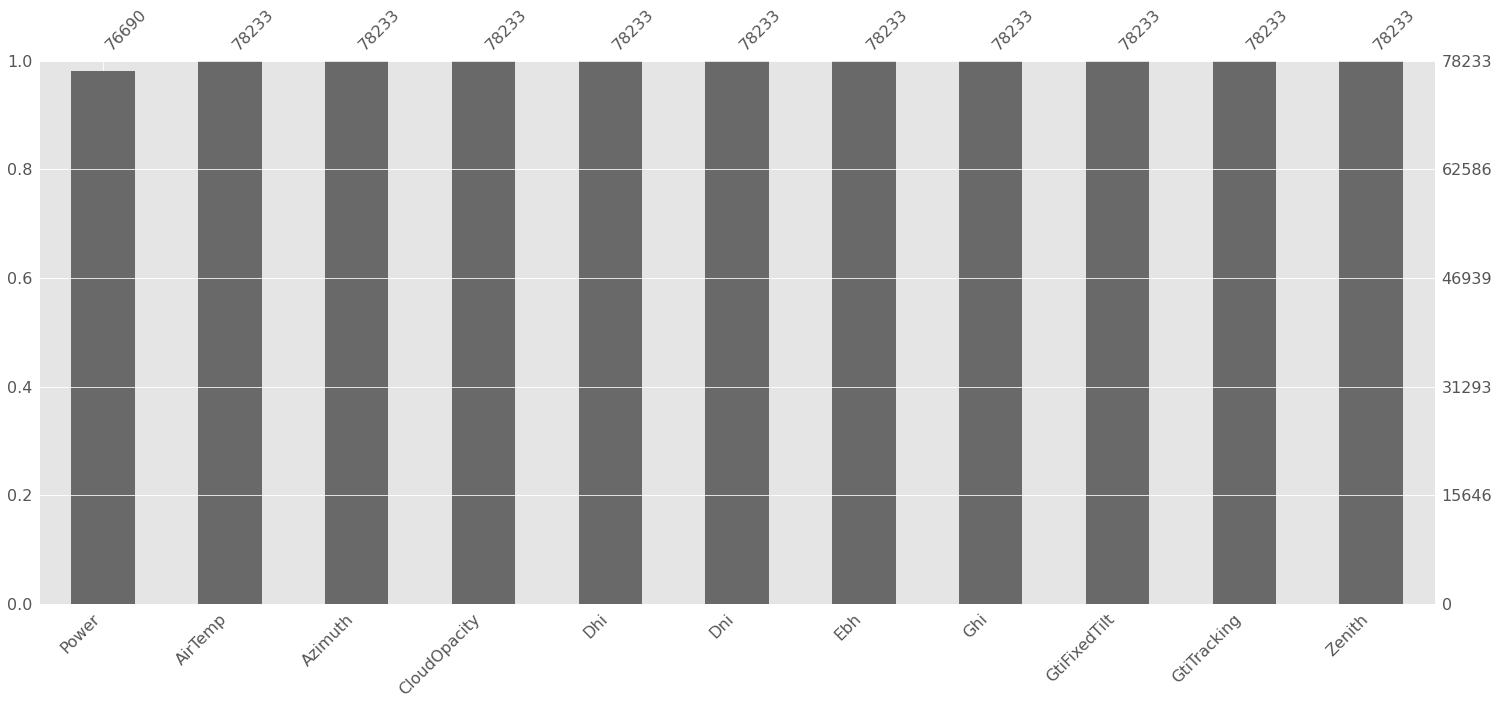

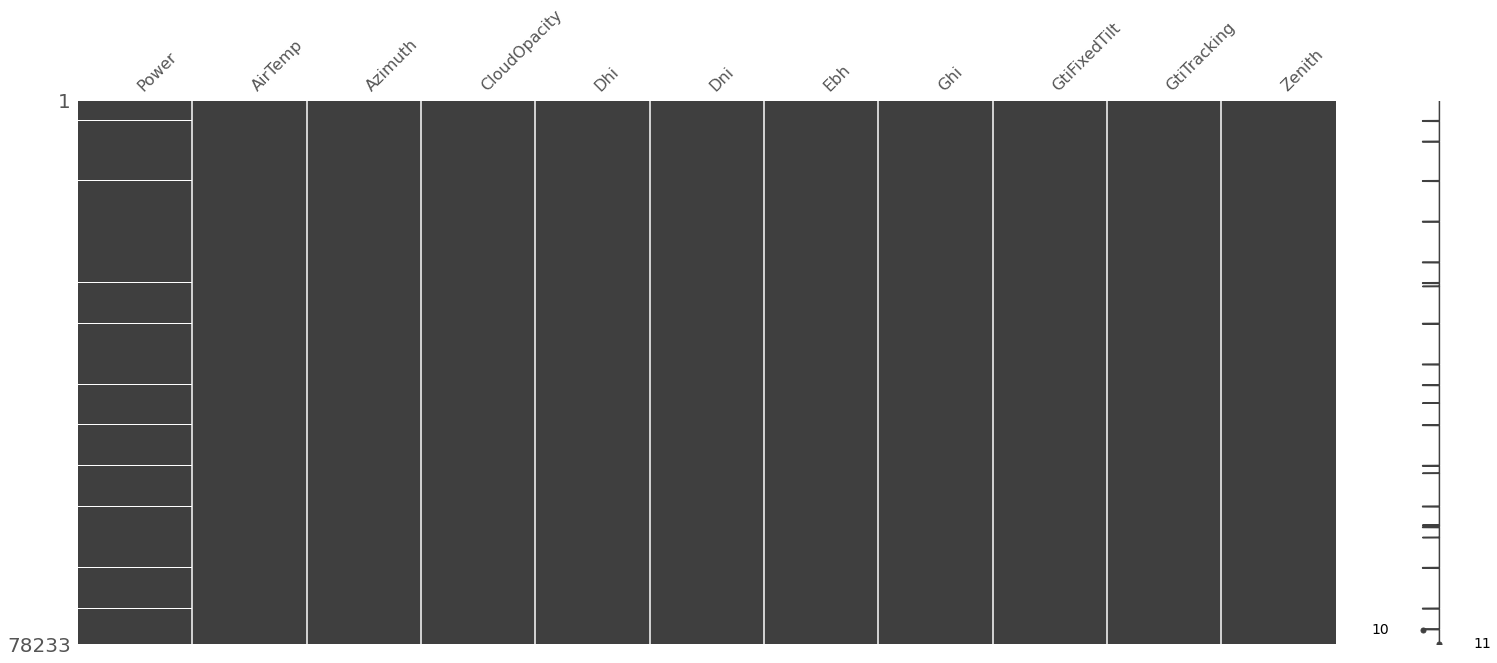

In [21]:
# Number of missing values in each column
percent_missing = round(data_final.isna().sum()* 100 / len(data_final), 1)
print(f'% of missing values in each column \n{percent_missing}')

# Plots of missing values
msno.bar(data_final)
plt.show()

msno.matrix(data_final)
plt.show()

# Delete rows with NaN values
data_final.dropna(axis= 0, subset= ['Power'], inplace= True)

# Replace NaN with last observed value - ffill
#data_final.fillna(method= 'ffill', inplace= True)

# Replace NaN with next observed value - bfill
# data_final.fillna(method= 'bfill', inplace= True)

# Replace NaN using linear interpolation
# data_final.interpolate(limit_direction= "both", inplace= True)

#### Creating features

In [28]:
%%time
# Creating date/time features using the datetime index
data_final = create_features(data_final)

data_final

Wall time: 155 ms


,Power,AirTemp,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,Zenith,Weekofyear,Dayofyear,Month,Dayofmonth,Dayofweek,Weekend,Season,Hour,Minute
Date,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,48,335,12,1,6,1,1,24,0
2018-12-01 00:15:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,48,335,12,1,6,1,1,24,15
2018-12-01 00:30:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,24,30
2018-12-01 00:45:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,24,45
2018-12-01 01:00:00,0.0,18.4,-20,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22 21:00:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,8,53,2,22,1,0,1,21,0
2021-02-22 21:15:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,8,53,2,22,1,0,1,21,15
2021-02-22 21:30:00,0.0,13.8,79,11.0,0,0,0,0,0,0,126,8,53,2,22,1,0,1,21,30


In [29]:
%%time
# Creating lag features for 1 day, 7 days (week) and 30 days (month) before
data_final = lag_features(data_final,[1,7,30], 'Power')
data_final.fillna(0, inplace= True)

data_final

Wall time: 9.57 ms


,Power,AirTemp,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,Zenith,Weekofyear,Dayofyear,Month,Dayofmonth,Dayofweek,Weekend,Season,Hour,Minute,Power_lag_1,Power_lag_7,Power_lag_30
Date,,,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,48,335,12,1,6,1,1,24,0,0.0,0.0,0.0
2018-12-01 00:15:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,48,335,12,1,6,1,1,24,15,0.0,0.0,0.0
2018-12-01 00:30:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,24,30,0.0,0.0,0.0
2018-12-01 00:45:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,24,45,0.0,0.0,0.0
2018-12-01 01:00:00,0.0,18.4,-20,0.0,0,0,0,0,0,0,168,48,335,12,1,6,1,1,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22 21:00:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,8,53,2,22,1,0,1,21,0,0.0,0.0,0.0
2021-02-22 21:15:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,8,53,2,22,1,0,1,21,15,0.0,0.0,0.0
2021-02-22 21:30:00,0.0,13.8,79,11.0,0,0,0,0,0,0,126,8,53,2,22,1,0,1,21,30,0.0,0.0,0.0


#### Outliers

In [30]:
# Converting negative values (if exist) to 0
data_final['Power'] = np.where(data_final.Power < 0, 0, data_final.Power)

In [31]:
# Removing outliers of PV generation before 05:00 am and after 20:00 pm
data_final['Power'] = np.where(data_final.Hour < 6, 0, data_final.Power)
data_final['Power'] = np.where(data_final.Hour > 19, 0, data_final.Power)

#### Exploratory Data Analysis (Plots)

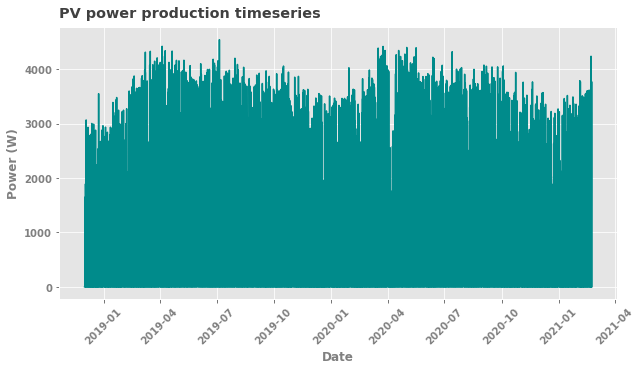

In [32]:
# Plot of the timeseries
plt.plot(data_final.index, data_final.Power, color= 'darkcyan')
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", rotation = 45)
plt.yticks(alpha= 0.75, weight= "bold")
plt.title("PV power production timeseries", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

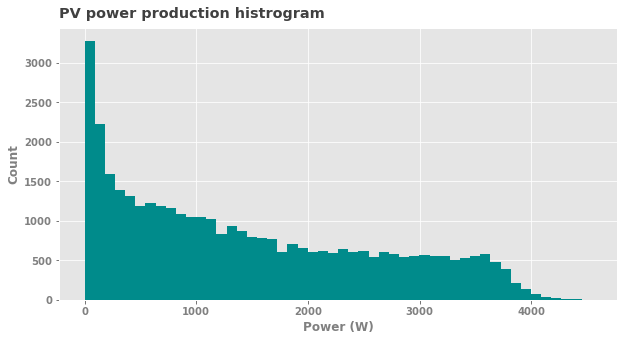

In [33]:
# Histogram of power
non_zero = data_final[data_final.Power > 0]
plt.hist(non_zero.Power, bins= 50, color= 'darkcyan')
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Power (W)", alpha= 0.75, weight= "bold")
plt.ylabel("Count", alpha= 0.75, weight= "bold")
plt.title("PV power production histrogram", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

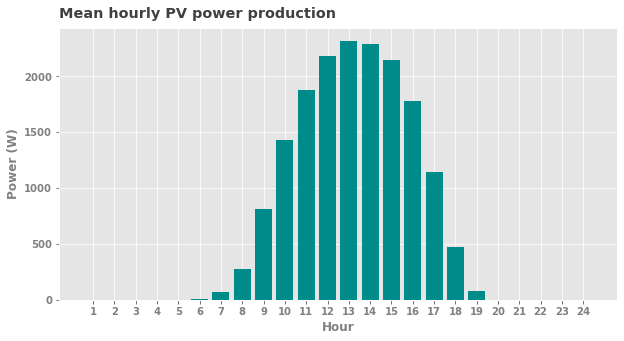

In [34]:
# Mean hourly production barplot
mean_per_hour = data_final.groupby('Hour')['Power'].agg(["mean"])
plt.bar(mean_per_hour.index, mean_per_hour["mean"], color= 'darkcyan')
plt.xticks(range(1,25), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Hour", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)",alpha= 0.75, weight= "bold")
plt.title("Mean hourly PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

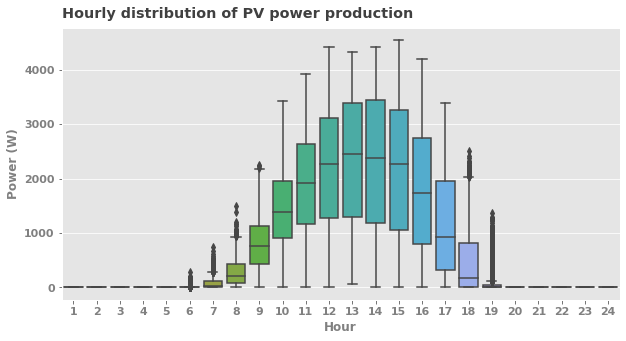

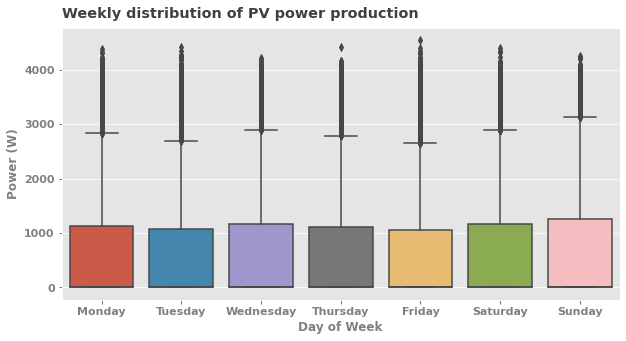

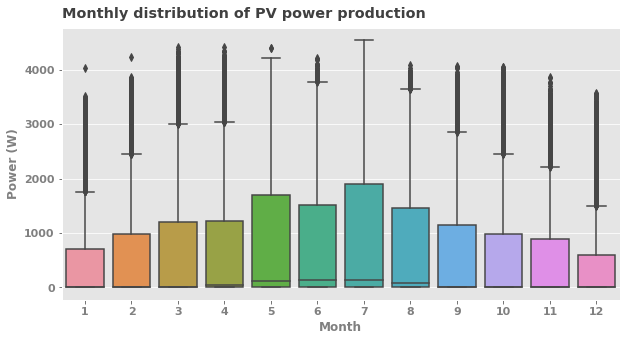

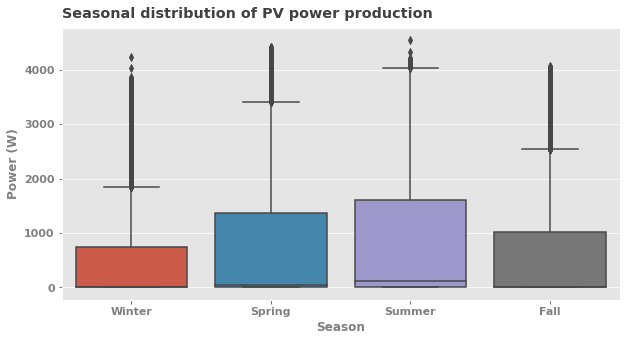

In [43]:
# Boxplots
sns.boxplot(x= data_final.Hour, y= data_final.Power)
plt.xlabel("Hour", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.title("Hourly distribution of PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.show()

sns.boxplot(x= data_final.Dayofweek, y= data_final.Power)
plt.xlabel("Day of Week", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=0)
plt.title("Weekly distribution of PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.show()

sns.boxplot(x= data_final.Month, y= data_final.Power)
plt.xlabel("Month", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.title("Monthly distribution of PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.show()

sns.boxplot(data= data_final, x= 'Season', y= 'Power')
plt.xlabel("Season", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks([0,1,2,3],['Winter', 'Spring', 'Summer','Fall'])
plt.title("Seasonal distribution of PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.show() 

### Clustering

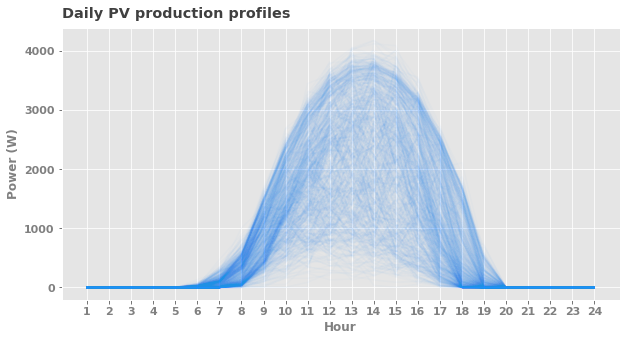

In [63]:
# Identifying daily patterns of PV power production
df_clusters = data_final.copy()
df_clusters = df_clusters.loc[:,['Power', 'Hour']]
df_clusters.reset_index(inplace=True)
df_clusters['Date'] = df_clusters['Date'].dt.date

df_pivot = df_clusters.pivot_table(index= 'Date', columns= 'Hour', values= 'Power')
df_pivot = df_pivot.dropna()
df_pivot.T.plot(legend= False, color= 'dodgerblue', alpha= 0.02)
plt.xlabel('Hour', alpha=0.75, weight="bold")
plt.ylabel('Power (W)', alpha=0.75, weight="bold")
plt.title('Daily PV production profiles', alpha= 0.75, weight= "bold", loc= "left", pad= 10) 
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.xticks(np.arange(1, 25, 1))
plt.show()

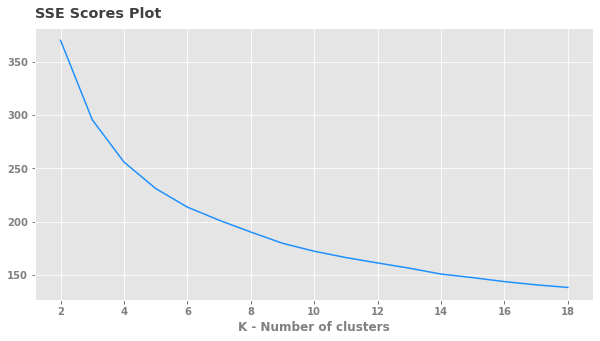

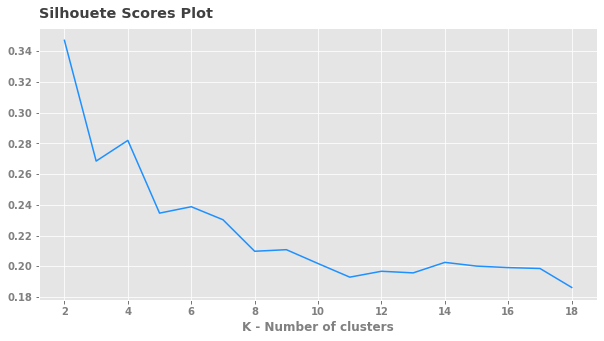

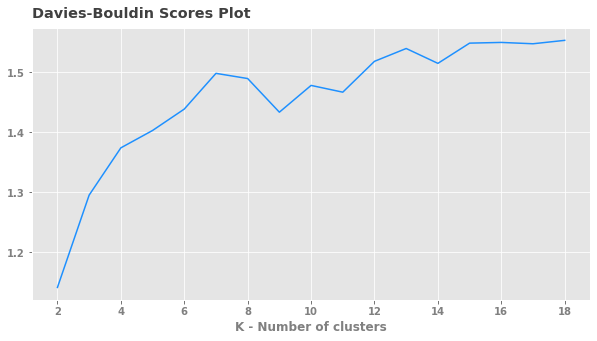

In [37]:
# Defining optimal number of clusters using different methods
X = df_pivot.values.copy() 
sc = MinMaxScaler()
X = sc.fit_transform(X)

n_cluster_list = np.arange(2,19).astype(int)

sillhoute_scores = []
davies_score = []
distortions = []

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters= n_cluster, init= 'k-means++', max_iter= 100, random_state= 0)
    kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
    davies_score.append(davies_bouldin_score(X,kmeans.labels_))
    distortions.append(kmeans.inertia_)

plt.plot(n_cluster_list, distortions, color= 'dodgerblue')
plt.title('SSE Scores Plot', alpha=0.75, weight="bold", loc="left", pad=10) 
plt.xlabel('K - Number of clusters', alpha=0.75, weight="bold")
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.show()

plt.plot(n_cluster_list,sillhoute_scores, color= 'dodgerblue')
plt.title('Silhouete Scores Plot', alpha=0.75, weight="bold", loc="left", pad=10)
plt.xlabel('K - Number of clusters', alpha=0.75, weight="bold")
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.show()

plt.plot(n_cluster_list,davies_score, color= 'dodgerblue')
plt.title('Davies-Bouldin Scores Plot', alpha=0.75, weight="bold", loc="left", pad=10)
plt.xlabel('K - Number of clusters', alpha=0.75, weight="bold")
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.show()

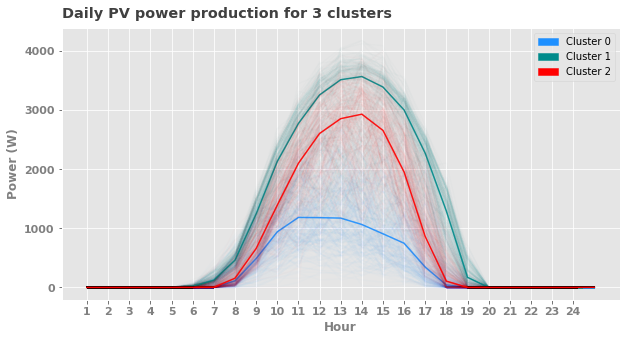

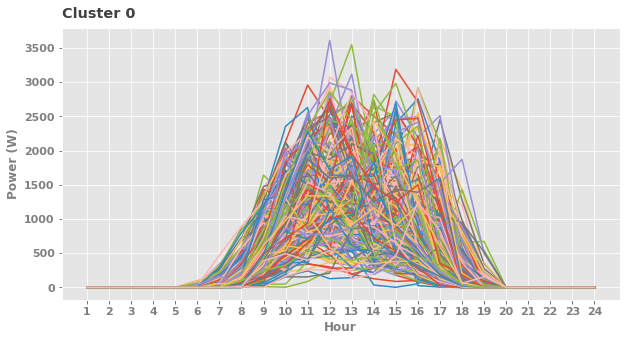

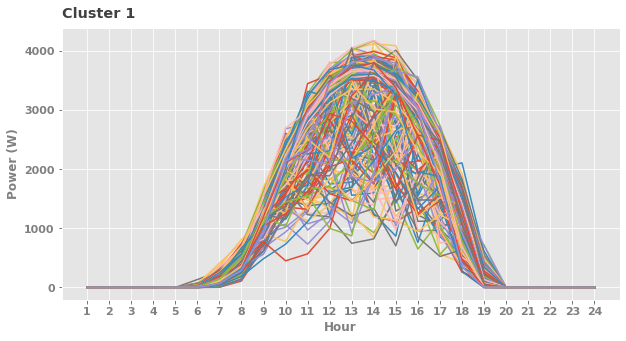

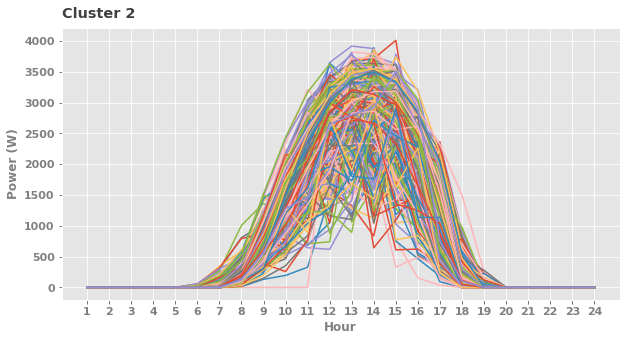

In [65]:
# Number of clusters
clusters = 3

kmeans = KMeans(n_clusters= clusters, random_state= 0)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name= 'Cluster')
df_pivot['Cluster']= cluster_found 

# Plot of the median for each cluster
df_pivot2 = df_pivot.copy()
df_pivot2 = df_pivot2.set_index(cluster_found_sr, append= True)

fig, ax = plt.subplots(1,1)
color_list = ['dodgerblue','darkcyan','red'] 
cluster_values = sorted(df_pivot2.index.get_level_values('Cluster').unique())
for cluster, color in zip(cluster_values, color_list):
    ax.set_xticks(np.arange(0,24))
    df_pivot2.xs(cluster, level= 1).T.plot(ax= ax, legend= False, alpha= 0.01, color= color)
    df_pivot2.xs(cluster, level= 1).median().plot(ax= ax, color= color, alpha= 0.9, label= cluster)

c_0 = mpatches.Patch(color= 'dodgerblue', label= 'Cluster 0')
c_1 = mpatches.Patch(color= 'darkcyan', label= 'Cluster 1')
c_2 = mpatches.Patch(color= 'red', label= 'Cluster 2')

plt.xlabel("Hour", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.legend(handles= [c_0, c_1, c_2])
plt.title('Daily PV power production for ' +str(clusters)+ ' clusters', alpha= 0.75, weight= "bold", loc= "left", pad= 10) 
plt.show()

# Plot of the profiles in each cluster
for cluster_id in sorted(df_pivot.Cluster.unique()):
    df_cluster = df_pivot.loc[df_pivot.Cluster == cluster_id].copy()
    df_cluster.drop(columns= ['Cluster'], inplace= True)
    df_cluster.T.plot(legend= None)
    plt.title(f'Cluster {cluster_id}', alpha= 0.75, weight= "bold", loc= "left", pad= 10)
    plt.xlabel('Hour', alpha= 0.75, weight= "bold")
    plt.ylabel('Power (W)', alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.xticks(np.arange(1, 25, 1))
    plt.show()

In [55]:
# Including clusters as a column (feature) in the dataframe
cluster_column = df_pivot.loc[:, ['Cluster']]
cluster_column.index = pd.to_datetime(cluster_column.index)

data_final['Cluster'] = cluster_column
data_final.fillna(method= 'ffill', inplace= True)
data_final = data_final.astype({"Cluster": int})

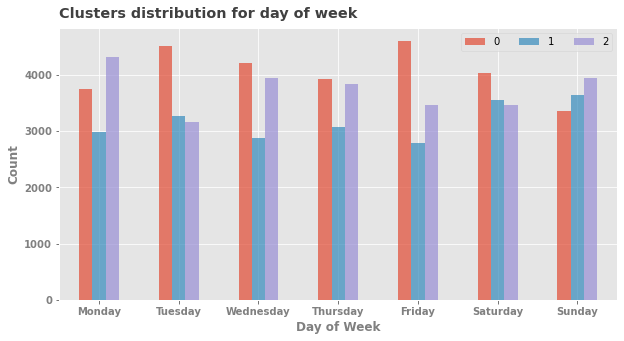

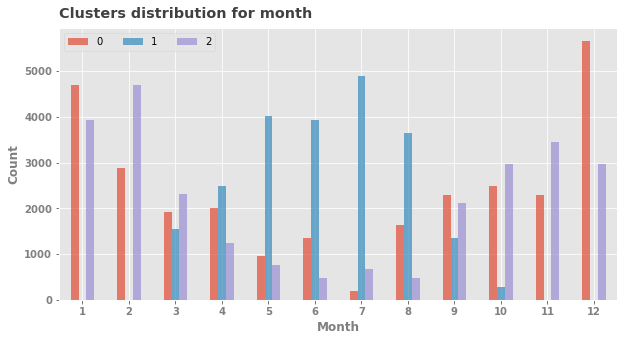

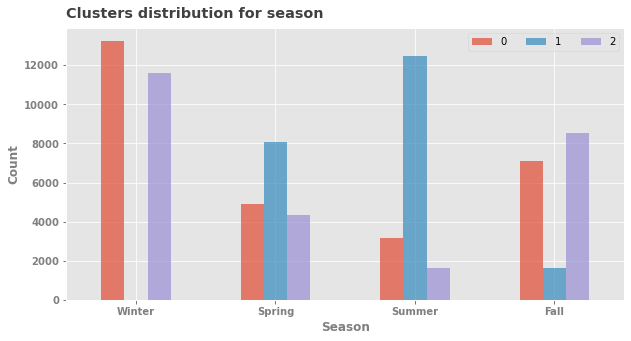

In [61]:
# Plots of clustering
fig, ax = plt.subplots()
data_final.groupby(['Dayofweek', 'Cluster']).size().unstack().plot(ax=ax, kind='bar', stacked=False, alpha=0.7)
plt.xlabel("Day of Week", alpha= 0.75, weight= "bold")
plt.ylabel("Count", alpha= 0.75, weight= "bold")
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], alpha=0.75,weight="bold")
plt.xticks(rotation=0)
plt.yticks(alpha=0.75,weight="bold")
ax.legend(ncol=3, loc= 'best')
plt.title("Clusters distribution for day of week", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

fig, ax = plt.subplots()
data_final.groupby(['Month', 'Cluster']).size().unstack().plot(ax=ax, kind='bar', stacked=False, alpha=0.7)
plt.xlabel("Month", alpha= 0.75, weight= "bold")
plt.ylabel("Count", alpha= 0.75, weight= "bold")
plt.xticks(rotation=0, alpha=0.75,weight="bold")
plt.yticks(alpha=0.75,weight="bold")
ax.legend(ncol=3, loc= 'best')
plt.title("Clusters distribution for month", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

fig, ax = plt.subplots()
data_final.groupby(['Season', 'Cluster']).size().unstack().plot(ax=ax, kind='bar', stacked=False, alpha=0.7)
plt.xlabel("Season", alpha= 0.75, weight= "bold")
plt.ylabel("Count", alpha= 0.75, weight= "bold")
plt.xticks([0,1,2,3],['Winter', 'Spring', 'Summer','Fall'], alpha=0.75,weight="bold")
plt.xticks(rotation=0)
plt.yticks(alpha=0.75,weight="bold")
ax.legend(ncol=3, loc= 'best')
plt.title("Clusters distribution for season", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

### Feature Selection

In [27]:
# Transforming date/time features into two dimensional features
data_final = cyclical_features(data_final)

data_final

,Power,AirTemp,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,Zenith,Weekend,Power_lag_1,Power_lag_7,Power_lag_30,Cluster,Weekofyear_x,Weekofyear_y,Dayofyear_x,Dayofyear_y,Season_x,Season_y,Month_x,Month_y,Dayofmonth_x,Dayofmonth_y,Dayofweek_x,Dayofweek_y,Hour_x,Hour_y,Minute_x,Minute_y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,1,0.0,0.0,0.0,0,0.885456,-0.464723,0.869589,-0.493776,6.123234e-17,1.0,1.0,-2.449294e-16,0.979530,0.201299,0.62349,-0.781831,1.000000,-2.449294e-16,1.0,0.000000e+00
2018-12-01 00:15:00,0.0,18.2,42,0.0,0,0,0,0,0,0,165,1,0.0,0.0,0.0,0,0.885456,-0.464723,0.869589,-0.493776,6.123234e-17,1.0,1.0,-2.449294e-16,0.979530,0.201299,0.62349,-0.781831,1.000000,-2.449294e-16,-0.5,8.660254e-01
2018-12-01 00:30:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,1,0.0,0.0,0.0,0,0.885456,-0.464723,0.869589,-0.493776,6.123234e-17,1.0,1.0,-2.449294e-16,0.979530,0.201299,0.62349,-0.781831,1.000000,-2.449294e-16,-0.5,-8.660254e-01
2018-12-01 00:45:00,0.0,18.3,14,0.0,0,0,0,0,0,0,168,1,0.0,0.0,0.0,0,0.885456,-0.464723,0.869589,-0.493776,6.123234e-17,1.0,1.0,-2.449294e-16,0.979530,0.201299,0.62349,-0.781831,1.000000,-2.449294e-16,1.0,-2.449294e-16
2018-12-01 01:00:00,0.0,18.4,-20,0.0,0,0,0,0,0,0,168,1,0.0,0.0,0.0,0,0.885456,-0.464723,0.869589,-0.493776,6.123234e-17,1.0,1.0,-2.449294e-16,0.979530,0.201299,0.62349,-0.781831,0.965926,2.588190e-01,1.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22 21:00:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,0,0.0,0.0,0.0,2,0.568065,0.822984,0.611886,0.790946,6.123234e-17,1.0,0.5,8.660254e-01,-0.250653,-0.968077,0.62349,0.781831,0.707107,-7.071068e-01,1.0,0.000000e+00
2021-02-22 21:15:00,0.0,14.0,84,3.8,0,0,0,0,0,0,119,0,0.0,0.0,0.0,2,0.568065,0.822984,0.611886,0.790946,6.123234e-17,1.0,0.5,8.660254e-01,-0.250653,-0.968077,0.62349,0.781831,0.707107,-7.071068e-01,-0.5,8.660254e-01
2021-02-22 21:30:00,0.0,13.8,79,11.0,0,0,0,0,0,0,126,0,0.0,0.0,0.0,2,0.568065,0.822984,0.611886,0.790946,6.123234e-17,1.0,0.5,8.660254e-01,-0.250653,-0.968077,0.62349,0.781831,0.707107,-7.071068e-01,-0.5,-8.660254e-01


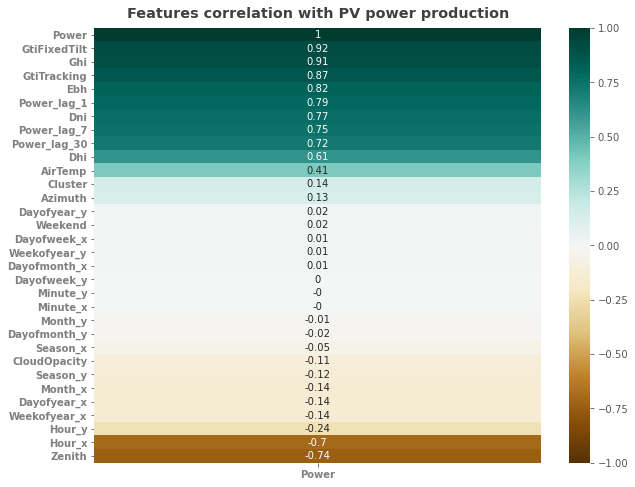

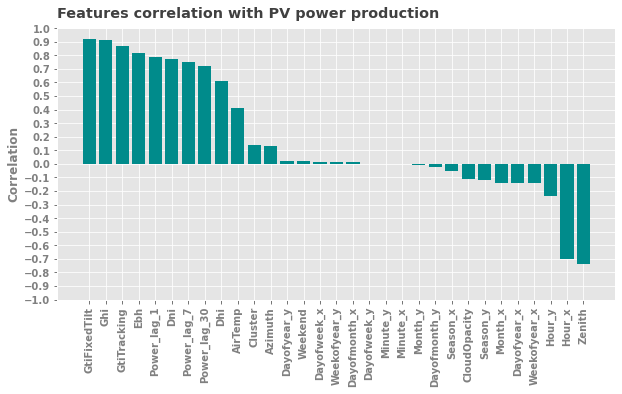

In [28]:
# Correlation matrix
corr = data_final.corr()[['Power']].sort_values(by= 'Power', ascending= False).round(2)

# Heatmap features correlation with Power
fig = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(corr, vmin= -1, vmax= 1, annot= True, cmap= 'BrBG')
heatmap.set_title('Features correlation with PV power production', alpha= 0.75, weight= "bold", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.show()

# Bar plot of features correlation with Power
plt.bar(corr[1:].index, corr[1:].Power, color= 'darkcyan')
plt.xticks(rotation= 90, alpha= 0.75, weight= "bold")
plt.yticks(np.arange(-1, 1.1, step= 0.1), alpha=0.75,  weight= "bold")
plt.ylabel('Correlation', alpha= 0.75, weight= "bold")
plt.title("Features correlation with PV power production", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

In [29]:
# Array containing the names of all features available
all_features = data_final.columns.values.tolist()
all_features.remove('Power')
all_features = np.array(all_features)

# Target variable and features (Y: Power, X: all features)
df_features = data_final.copy().values
Y = df_features[:, 0] 
X = df_features[:, [x for x in range(1, len(all_features)+1)]]

In [30]:
%%time
# Filter method - K best
features1 = SelectKBest(k= 15, score_func= mutual_info_regression)
fit1 = features1.fit(X, Y)
filter1 = all_features[fit1.get_support()]

print('Best 15 features - Filter method (K best)')
print(filter1)

Best 15 features - Filter method (K best)
['AirTemp' 'Azimuth' 'CloudOpacity' 'Dhi' 'Dni' 'Ebh' 'Ghi' 'GtiFixedTilt'
 'GtiTracking' 'Zenith' 'Power_lag_1' 'Power_lag_7' 'Power_lag_30'
 'Hour_x' 'Hour_y']
Wall time: 37.6 s


In [31]:
%%time
# Feature importance Random Forest
model2 = RandomForestRegressor()
fit2 = model2.fit(X, Y)
importance2 = pd.DataFrame(data= {'Feature': all_features, 'Score': model2.feature_importances_})
importance2 = importance2.sort_values(by= ['Score'], ascending= False)
importance2.set_index('Feature', inplace= True)

print('Best 15 features - RF')
print(importance2.head(15))

Best 15 features - RF
                 Score
Feature               
GtiFixedTilt  0.777152
Ghi           0.050239
Hour_y        0.043020
Ebh           0.024449
Cluster       0.012629
Power_lag_1   0.010409
GtiTracking   0.009241
Power_lag_7   0.007432
AirTemp       0.007067
Power_lag_30  0.006667
CloudOpacity  0.006155
Azimuth       0.005471
Dhi           0.004896
Zenith        0.004477
Dayofyear_x   0.004152
Wall time: 2min


In [32]:
%%time
# Feature importance XGBOOST
model3 = xgb.XGBRegressor()
fit3 = model3.fit(X, Y)
importance3 = pd.DataFrame(data= {'Feature': all_features, 'Score': model3.feature_importances_})
importance3 = importance3.sort_values(by= ['Score'], ascending= False)
importance3.set_index('Feature', inplace= True)

print('Best 15 features - XGBOOST')
print(importance3.head(15))

Best 15 features - XGBOOST
                 Score
Feature               
GtiFixedTilt  0.664540
Hour_y        0.103358
Ghi           0.089038
Ebh           0.027178
Cluster       0.022566
Season_y      0.011467
GtiTracking   0.010226
Hour_x        0.007870
Zenith        0.005814
Season_x      0.005313
Power_lag_1   0.004448
Dayofyear_x   0.004377
Dayofyear_y   0.003261
CloudOpacity  0.003235
Weekofyear_y  0.003024
Wall time: 4.32 s


### Forecasting

#### Plots of daily PV power profiles for a period (to define the start of the forecast)

Period defined: 2021-01-10 to 2021-01-20


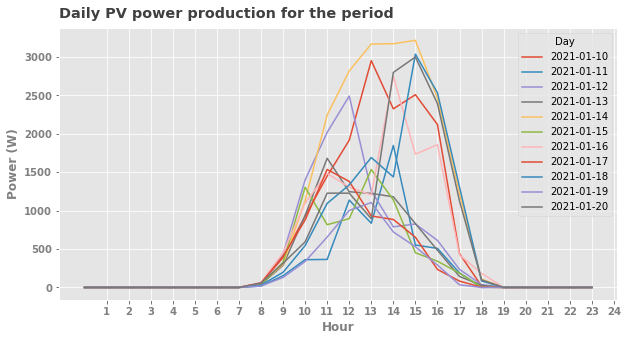

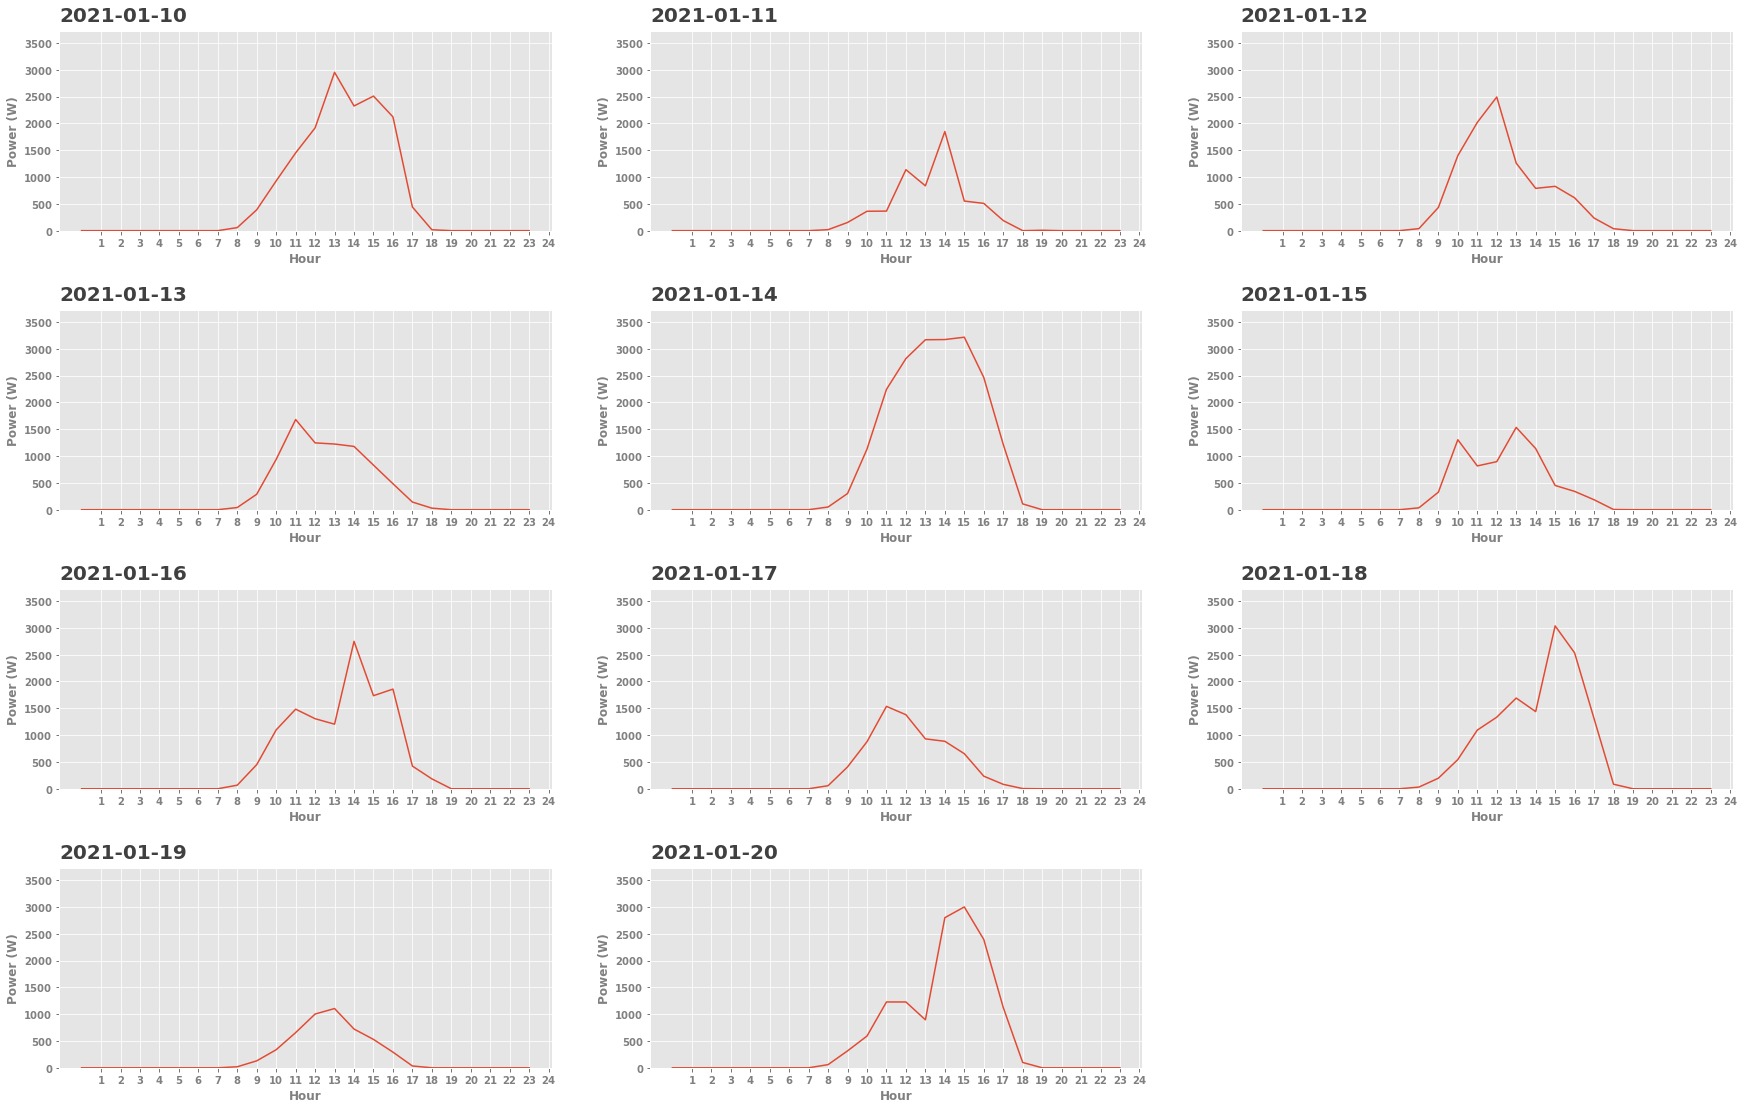

In [73]:
# INPUT the period to analyze (start and end date)
date_start = '2021-01-10'
date_end = '2021-01-20'
print(f'Period defined: {date_start} to {date_end}')
    
data2 = data_final.loc[date_start:date_end, :].copy()
data2 = data2.resample('H').mean()
data2['Day'] = data2.index.date
data2['Hour'] = data2.index.hour
data2 = data2.loc[:, ['Power', 'Day', 'Hour']]

# Daily PV power profiles for the period defined
data2_pivot = data2.pivot_table(index='Day', values='Power', columns= 'Hour')     
data2_pivot.T.plot()
plt.xlabel("Hour", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.title("Daily PV power production for the period", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.xticks(np.arange(1, 25, 1))
plt.show()

# Individual profiles
size = len(data2.Day.unique())
fig = plt.figure(figsize= (30, size*5))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
    
for i, day in enumerate(data2.Day.unique()):
    data_temp = data2[data2.Day == day]
    ax = fig.add_subplot(round(size+1/3), 3, i+1)
    sns.lineplot(data= data_temp, x= 'Hour', y='Power')
    plt.xlabel("Hour", alpha= 0.75, weight= "bold")
    plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold")
    plt.yticks(alpha= 0.75, weight= "bold")
    plt.title(day, alpha= 0.75, weight= "bold", loc= "left", pad= 10, fontsize= 20)
    ax.set_ylim(bottom=0, top= data2.Power.max()+500)
    plt.xticks(np.arange(1, 25, 1))

plt.show()

#### Inputs

In [34]:
# Define the start date of the forecast
start_forecast = datetime.strptime('2021-01-14', '%Y-%m-%d')

# Define the number of days to forecast
days_to_forecast = 1

# Define forecast variable and features
FORECAST_COLUMN = ['Power']

FEATURE_COLUMNS =  ['GtiFixedTilt', 'GtiTracking', 'Ghi', 'Dhi', 'Dni', 'Ebh', 'Zenith', 'Azimuth',
                    'AirTemp', 'CloudOpacity', 'Hour_x', 'Hour_y',
                    'Power_lag_1', 'Power_lag_7', 'Power_lag_30']

print(f'Forecast variable: {FORECAST_COLUMN}')
print(f'Features: {FEATURE_COLUMNS}')

Forecast variable: ['Power']
Features: ['GtiFixedTilt', 'GtiTracking', 'Ghi', 'Dhi', 'Dni', 'Ebh', 'Zenith', 'Azimuth', 'AirTemp', 'CloudOpacity', 'Hour_x', 'Hour_y', 'Power_lag_1', 'Power_lag_7', 'Power_lag_30']


In [35]:
# The start of the training is always the beginning of the dataset
start_training = data_final.index[0]

# The end of the training is always 15min before the start of the forecast
end_training = start_forecast - timedelta(minutes= 15)
        
# The end of the forecast is obtained from the # of days to forecast defined
end_forecast = start_forecast + timedelta(days= days_to_forecast) - timedelta(minutes= 15)

# Print of training and forecast periods
print(f'Data available: {data_final.index[0].date()} to {data_final.index[-1].date()}')
print(f'Days to forecast: {days_to_forecast}')
print(f'Training period: {start_training.date()} to {end_training.date()}')
print(f'Forecast period: {start_forecast.date()} to {end_forecast.date()}')

Data available: 2018-12-01 to 2021-02-22
Days to forecast: 1
Training period: 2018-12-01 to 2021-01-13
Forecast period: 2021-01-14 to 2021-01-14


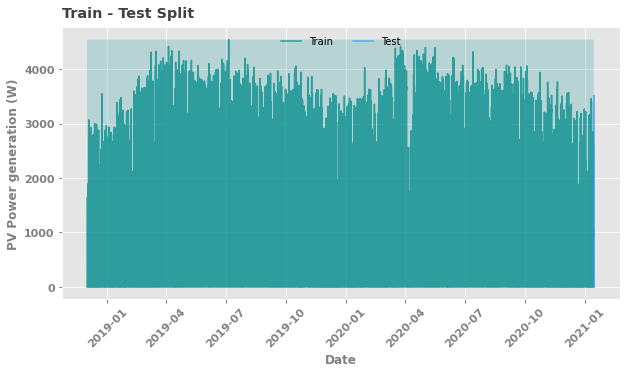

In [36]:
# Dividing into train and test sets
data_train = data_final.loc[start_training : end_training, :].copy()
data_test = data_final.loc[start_forecast : end_forecast, :].copy()

xtrain = data_train.loc[:, FEATURE_COLUMNS]
ytrain = data_train.loc[:, FORECAST_COLUMN]

xtest = data_test.loc[:, FEATURE_COLUMNS]
ytest = data_test.loc[:, FORECAST_COLUMN]
        
# Plot train-test split
fig, ax = plt.subplots()
coloring = data_final.Power.max()
plt.plot(data_train.index, data_train["Power"], color= "darkcyan", alpha= 0.75)
plt.fill_between(data_train.index, coloring, facecolor= "darkcyan", alpha= 0.2)
plt.plot(data_test.index, data_test["Power"], color= "dodgerblue", alpha= 0.60)
plt.fill_between(data_test.index, coloring, facecolor= "dodgerblue", alpha= 0.2)
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("PV Power generation (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75,weight= "bold", fontsize= 11, rotation = 45)
plt.yticks(alpha= 0.75,weight= "bold", fontsize= 11)
plt.legend(['Train','Test'], frameon= False, loc= 'upper center', ncol= 2)
plt.title("Train - Test Split", alpha=0.75, weight="bold", pad=10, loc="left")
plt.show()

#### Random Forest

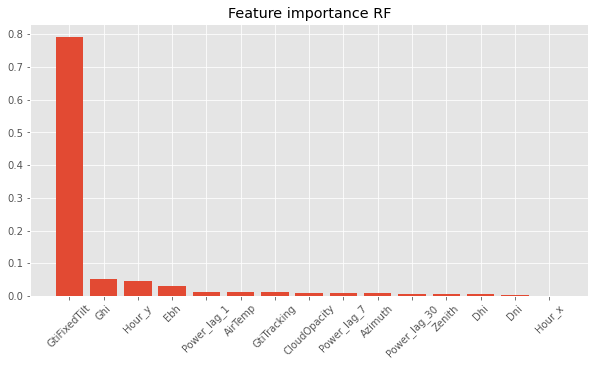

Wall time: 1min 36s


In [37]:
%%time
# Model
parameters_RF = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 200, 
              'min_samples_split': 7,
              'max_depth': 30,
              'max_leaf_nodes': None,
              'random_state': 18}

reg_RF = RandomForestRegressor(**parameters_RF)
reg_RF.fit(xtrain, np.ravel(ytrain))

# Feature importance
importances = reg_RF.feature_importances_
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:len(FEATURE_COLUMNS)]
x = range(len(sorted_index_top))

labels = np.array(FEATURE_COLUMNS)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label= labels)
plt.title("Feature importance RF")
plt.xticks(rotation= 45)
plt.show()

# Predictions and pos-processing
df_RF = pd.DataFrame(reg_RF.predict(xtest), columns= ['Prediction'], index= xtest.index)
df_RF['Real'] = ytest
df_RF['Prediction'] = np.where(df_RF['Prediction'] < 0, 0 , df_RF['Prediction'])
df_RF['Prediction'] = np.where((df_RF.index.hour < 6) | (df_RF.index.hour > 19) , 0, df_RF['Prediction'])

In [38]:
# Forecasts obatined for Random Forest
pd.set_option('display.max_rows', None)
df_RF

,Prediction,Real
Date,,
2021-01-14 00:00:00,0.000000,0.000000
2021-01-14 00:15:00,0.000000,0.000000
2021-01-14 00:30:00,0.000000,0.000000
2021-01-14 00:45:00,0.000000,0.000000
2021-01-14 01:00:00,0.000000,0.000000
2021-01-14 01:15:00,0.000000,0.000000
2021-01-14 01:30:00,0.000000,0.000000
2021-01-14 01:45:00,0.000000,0.000000
2021-01-14 02:00:00,0.000000,0.000000


In [39]:
# Errors
MAE_RF, RMSE_RF, normRMSE_RF, R2_RF = compute_errors(df_RF, ytest.Power.max())

print(f'RF - Mean Absolute Error (MAE): {MAE_RF:.2f} W')
print(f'RF - Root Mean Square Error (RMSE): {RMSE_RF:.2f} W')
print(f'RF - Normalized RMSE: {normRMSE_RF:.2f} %')
print(f'RF - R square: {R2_RF:.2f}')

RF - Mean Absolute Error (MAE): 116.50 W
RF - Root Mean Square Error (RMSE): 242.04 W
RF - Normalized RMSE: 6.88 %
RF - R square: 0.96


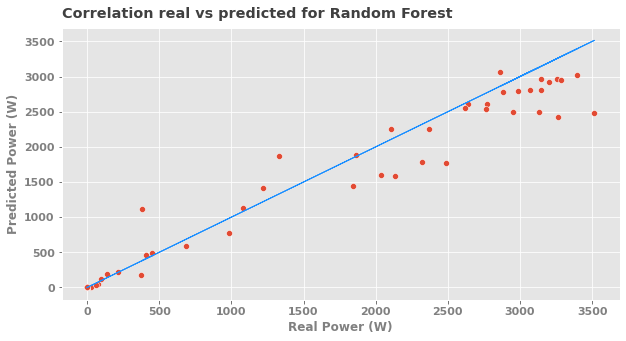

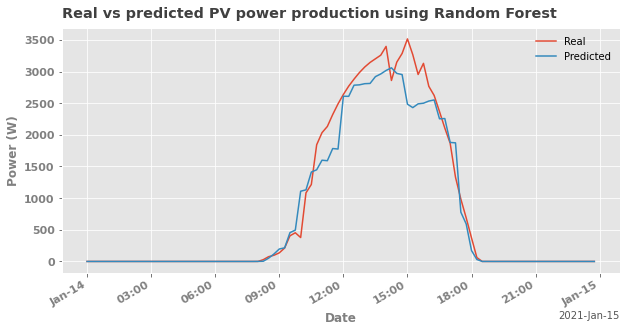

In [40]:
# Plots real vs predicted
result_plots(df_RF, 'Random Forest')

#### XGBOOST

[0]	validation_0-rmse:1282.44095	validation_1-rmse:1473.34704
[50]	validation_0-rmse:819.65507	validation_1-rmse:943.17555
[100]	validation_0-rmse:558.08036	validation_1-rmse:623.04236
[150]	validation_0-rmse:420.01924	validation_1-rmse:427.53292
[200]	validation_0-rmse:353.28427	validation_1-rmse:311.16974
[250]	validation_0-rmse:322.70510	validation_1-rmse:242.05365
[299]	validation_0-rmse:308.55202	validation_1-rmse:208.01999


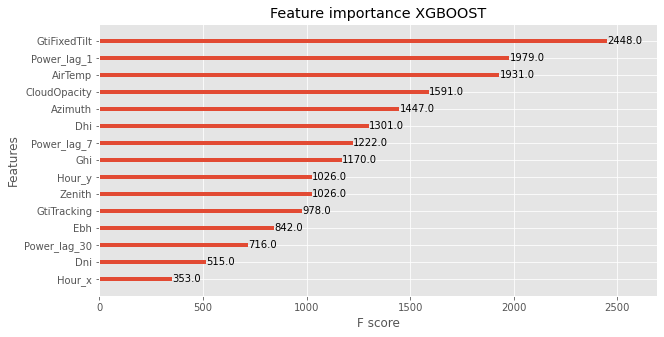

Wall time: 14 s


In [41]:
%%time
# Model
parameters_XGBOOST = {'n_estimators' : 300,
                      'learning_rate' : 0.01,
                      'verbosity' : 0,
                      'n_jobs' : -1,
                      'gamma' : 0,
                      'min_child_weight' : 1,
                      'max_delta_step' : 0,
                      'subsample' : 0.7,
                      'colsample_bytree' : 1,
                      'colsample_bylevel' : 1,
                      'colsample_bynode' : 1,
                      'reg_alpha' : 0,
                      'reg_lambda' : 1,
                      'random_state' : 18,
                      'objective' : 'reg:linear',
                      'booster' : 'gbtree'}

reg_XGBOOST = xgb.XGBRegressor(**parameters_XGBOOST)
reg_XGBOOST.fit(xtrain, ytrain, 
                eval_set= [(xtrain, ytrain), (xtest, ytest)],
                verbose= 50)

# Feature Importance
plot_importance(reg_XGBOOST)
plt.title("Feature importance XGBOOST")
plt.show()

# Predictions and pos-processing
df_xgboost = pd.DataFrame(reg_XGBOOST.predict(xtest), columns= ['Prediction'], index= xtest.index)
df_xgboost['Real'] = ytest
df_xgboost['Prediction'] = np.where(df_xgboost['Prediction'] < 0, 0 , df_xgboost['Prediction'])
df_xgboost['Prediction'] = np.where((df_xgboost.index.hour < 6) | (df_xgboost.index.hour > 19) , 0, df_xgboost['Prediction'])

In [42]:
# Forecasts obtained for XGBOOST
pd.set_option('display.max_rows', None)
df_xgboost

,Prediction,Real
Date,,
2021-01-14 00:00:00,0.000000,0.000000
2021-01-14 00:15:00,0.000000,0.000000
2021-01-14 00:30:00,0.000000,0.000000
2021-01-14 00:45:00,0.000000,0.000000
2021-01-14 01:00:00,0.000000,0.000000
2021-01-14 01:15:00,0.000000,0.000000
2021-01-14 01:30:00,0.000000,0.000000
2021-01-14 01:45:00,0.000000,0.000000
2021-01-14 02:00:00,0.000000,0.000000


In [43]:
# Errors
MAE_XGBOOST, RMSE_XGBOOST, normRMSE_XGBOOST, R2_XGBOOST = compute_errors(df_xgboost, ytest.Power.max())

print(f'XGBOOST - Mean Absolute Error (MAE): {MAE_XGBOOST:.2f} W')
print(f'XGBOOST - Root Mean Square Error (RMSE): {RMSE_XGBOOST:.2f} W')
print(f'XGBOOST - Normalized RMSE: {normRMSE_XGBOOST:.2f} %')
print(f'XGBOOST - R square: {R2_XGBOOST:.2f}')

XGBOOST - Mean Absolute Error (MAE): 108.09 W
XGBOOST - Root Mean Square Error (RMSE): 207.84 W
XGBOOST - Normalized RMSE: 5.91 %
XGBOOST - R square: 0.97


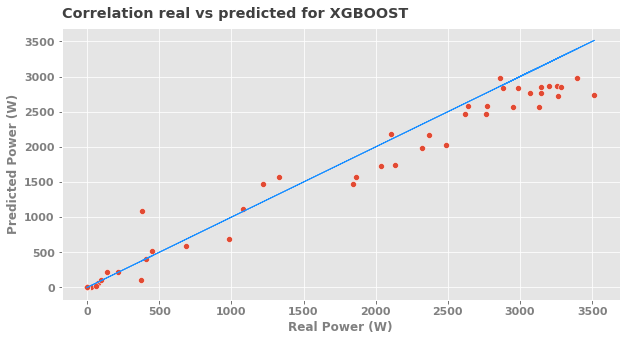

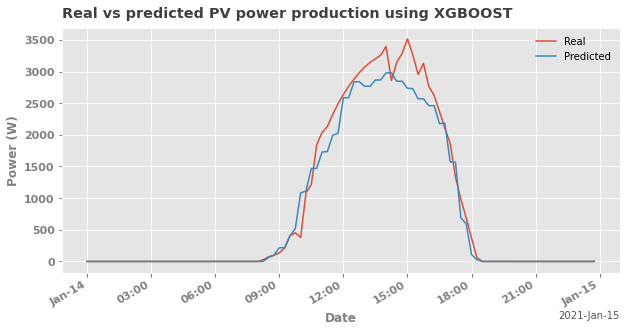

In [44]:
# Plots real vs predicted
result_plots(df_xgboost, 'XGBOOST')

### Predicting the future

In [45]:
%%time
# Dividing all data between features (X) and target variable (y)
X_all = data_final.loc[:, FEATURE_COLUMNS].copy()
y_all = data_final.loc[:, FORECAST_COLUMN].copy()

# XGBOOST model training with all data
parameters_XGBOOST = {'n_estimators' : 500,
                      'learning_rate' : 0.01,
                      'verbosity' : 0,
                      'n_jobs' : -1,
                      'gamma' : 0,
                      'min_child_weight' : 1,
                      'max_delta_step' : 0,
                      'subsample' : 0.7,
                      'colsample_bytree' : 1,
                      'colsample_bylevel' : 1,
                      'colsample_bynode' : 1,
                      'reg_alpha' : 0,
                      'reg_lambda' : 1,
                      'random_state' : 18,
                      'objective' : 'reg:linear',
                      'booster' : 'gbtree'}

reg_XGBOOST_future = xgb.XGBRegressor(**parameters_XGBOOST)
reg_XGBOOST_future.fit(X_all, y_all, 
                       eval_set= [(X_all, y_all)],
                       verbose= 100)

[0]	validation_0-rmse:1274.91586
[100]	validation_0-rmse:555.22581
[200]	validation_0-rmse:351.80689
[300]	validation_0-rmse:307.22101
[400]	validation_0-rmse:294.51590
[499]	validation_0-rmse:288.08686
Wall time: 29.4 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500,
             n_jobs=-1, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=18, reg_alpha=0, ...)

In [46]:
# INPUT the number of days to forecast in the future 
days_future = 1

# Creating future dataframe
df_future = pd.DataFrame(index=pd.date_range(start= data_final.index[-1] + timedelta(minutes = 15), freq= '15min', periods= 96 * days_future))
df_future['isFuture'] = True

power_15min.dropna(axis= 0, subset= ['Power'], inplace= True)
power_15min['isFuture'] = False

data_future = pd.concat([power_15min, df_future])
data_future = create_features(data_future)
data_future = lag_features(data_future,[1,7,30], 'Power')
data_future = cyclical_features(data_future)
data_future = pd.merge(data_future, meteo_15min, left_index= True, right_index= True)

test_future = data_future.query('isFuture').loc[:, FEATURE_COLUMNS]

test_future

Wall time: 420 ms


,GtiFixedTilt,GtiTracking,Ghi,Dhi,Dni,Ebh,Zenith,Azimuth,AirTemp,CloudOpacity,Hour_x,Hour_y,Power_lag_1,Power_lag_7,Power_lag_30
2021-02-22 22:15:00,0,0,0,0,0,0,132,74,13.7,36.7,8.660254e-01,-5.000000e-01,0.000000,0.000000,0.000000
2021-02-22 22:30:00,0,0,0,0,0,0,138,67,13.6,18.8,8.660254e-01,-5.000000e-01,0.000000,0.000000,0.000000
2021-02-22 22:45:00,0,0,0,0,0,0,138,67,13.6,18.8,8.660254e-01,-5.000000e-01,0.000000,0.000000,0.000000
2021-02-22 23:00:00,0,0,0,0,0,0,143,60,13.6,19.9,9.659258e-01,-2.588190e-01,0.000000,0.000000,0.000000
2021-02-22 23:15:00,0,0,0,0,0,0,143,60,13.6,19.9,9.659258e-01,-2.588190e-01,0.000000,0.000000,0.000000
2021-02-22 23:30:00,0,0,0,0,0,0,148,50,13.6,11.0,9.659258e-01,-2.588190e-01,0.000000,0.000000,0.000000
2021-02-22 23:45:00,0,0,0,0,0,0,148,50,13.6,11.0,9.659258e-01,-2.588190e-01,0.000000,0.000000,0.000000
2021-02-23 00:00:00,0,0,0,0,0,0,153,38,13.6,7.6,1.000000e+00,-2.449294e-16,0.000000,0.000000,0.000000
2021-02-23 00:15:00,0,0,0,0,0,0,153,38,13.6,7.6,1.000000e+00,-2.449294e-16,0.000000,0.000000,0.000000
2021-02-23 00:30:00,0,0,0,0,0,0,156,23,13.5,10.0,1.000000e+00,-2.449294e-16,0.000000,0.000000,0.000000


In [47]:
# Generating the predictions and pos-processing
xgboost_future = pd.DataFrame(reg_XGBOOST_future.predict(test_future), columns= ['Prediction'], index= test_future.index)
xgboost_future['Prediction'] = np.where(xgboost_future['Prediction'] < 0, 0 , xgboost_future['Prediction'])
xgboost_future['Prediction'] = np.where((xgboost_future.index.hour < 6) | (xgboost_future.index.hour > 19) , 0, xgboost_future['Prediction'])

pd.set_option('display.max_rows', None)
xgboost_future

,Prediction
2021-02-22 22:15:00,0.000000
2021-02-22 22:30:00,0.000000
2021-02-22 22:45:00,0.000000
2021-02-22 23:00:00,0.000000
2021-02-22 23:15:00,0.000000
2021-02-22 23:30:00,0.000000
2021-02-22 23:45:00,0.000000
2021-02-23 00:00:00,0.000000
2021-02-23 00:15:00,0.000000
2021-02-23 00:30:00,0.000000


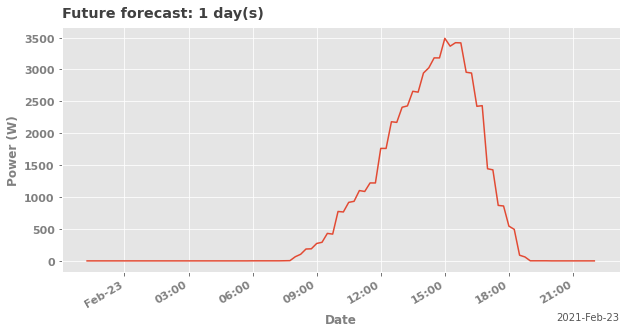

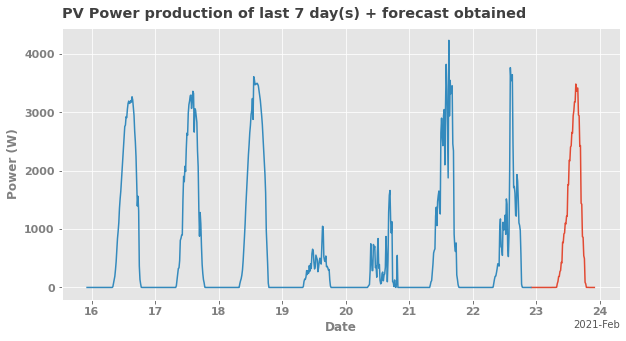

In [48]:
# Plot of future forecast
fig, ax = plt.subplots()
ax.plot(xgboost_future.Prediction)
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11, rotation = 45)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.title(f"Future forecast: {days_future} day(s)", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
locator = AutoDateLocator()
date_form = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()
plt.show()

# Plot of last past_days (defined) + future forecast
past_days = 7
fig, ax = plt.subplots()
ax.plot(xgboost_future.Prediction)
ax.plot(data_future.Power[-96 * (past_days + days_future) : -96* days_future])
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.title(f"PV Power production of last {past_days} day(s) + forecast obtained", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
locator = AutoDateLocator()
date_form = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(date_form)
plt.show()

### Cross Validation

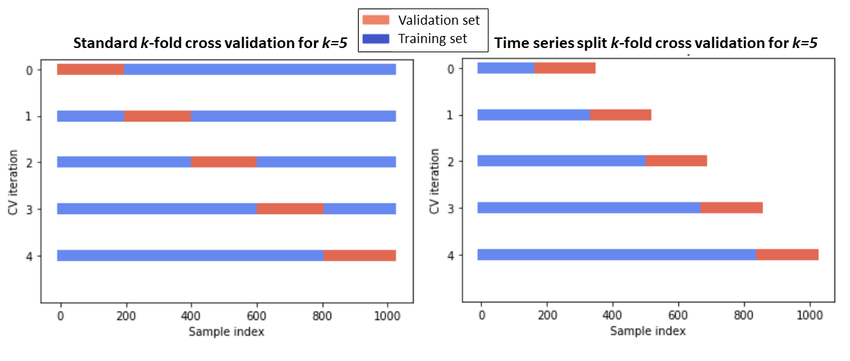

In [49]:
df_cv = data_final.copy()

parameters_XGBOOST = {'n_estimators' : 1000,
                      'learning_rate' : 0.01,
                      'verbosity' : 0,
                      'n_jobs' : -1,
                      'gamma' : 0,
                      'min_child_weight' : 1,
                      'max_delta_step' : 0,
                      'subsample' : 0.7,
                      'colsample_bytree' : 1,
                      'colsample_bylevel' : 1,
                      'colsample_bynode' : 1,
                      'reg_alpha' : 0,
                      'reg_lambda' : 1,
                      'random_state' : 18,
                      'objective' : 'reg:linear',
                      'booster' : 'gbtree'}

reg_XGBOOST_cv = xgb.XGBRegressor(**parameters_XGBOOST)

#### Cross_val_score

In [50]:
%%time
X_cv = df_cv[FEATURE_COLUMNS]
y_cv = df_cv[FORECAST_COLUMN]

cv_results = cross_val_score(reg_XGBOOST_cv, X_cv, y_cv, cv=5, scoring='neg_root_mean_squared_error')

rmse_mean = -1 * cv_results.mean()
norm_rmse_mean = 100 * (rmse_mean / ytest.Power.max())

print(f'Cross_val_mean RMSE: {rmse_mean} W')
print(f'Cross_val_mean Normalized RMSE: {norm_rmse_mean:.2f} %')

Cross_val_mean RMSE: 335.4450084598381 W
Cross_val_mean Normalized RMSE: 9.54 %
Wall time: 3min 40s


#### Time Series Split

In [51]:
%%time
tss = TimeSeriesSplit(n_splits= 5, test_size= 96 * days_to_forecast)

xgboost_cv = pd.DataFrame()

for train_idx, val_idx in tss.split(df_cv):
    
    train_cv = df_cv.iloc[train_idx]
    test_cv = df_cv.iloc[val_idx]

    xtrain_cv = train_cv[FEATURE_COLUMNS]
    ytrain_cv = train_cv[FORECAST_COLUMN]

    xtest_cv = test_cv[FEATURE_COLUMNS]
    ytest_cv = test_cv[FORECAST_COLUMN]

    reg_XGBOOST_cv.fit(xtrain_cv, ytrain_cv, 
                    eval_set= [(xtrain_cv, ytrain_cv), (xtest_cv, ytest_cv)],
                    early_stopping_rounds= 50,
                    verbose= 100)

    ypred_cv = pd.DataFrame(reg_XGBOOST_cv.predict(xtest_cv), columns= ['Prediction'], index= xtest_cv.index)
    ypred_cv['Real'] = ytest_cv
    xgboost_cv = xgboost_cv.append(ypred_cv)

xgboost_cv['Prediction'] = np.where(xgboost_cv['Prediction'] < 0, 0 , xgboost_cv['Prediction'])
xgboost_cv['Prediction'] = np.where((xgboost_cv.index.hour < 6) | (xgboost_cv.index.hour > 19) , 0, xgboost_cv['Prediction'])

[0]	validation_0-rmse:1275.95703	validation_1-rmse:1629.73485
[100]	validation_0-rmse:555.60347	validation_1-rmse:679.62551
[200]	validation_0-rmse:352.13863	validation_1-rmse:322.91298
[300]	validation_0-rmse:307.51957	validation_1-rmse:200.48858
[400]	validation_0-rmse:295.14340	validation_1-rmse:164.39767
[500]	validation_0-rmse:288.70525	validation_1-rmse:154.92469
[600]	validation_0-rmse:283.71980	validation_1-rmse:151.56326
[700]	validation_0-rmse:279.67883	validation_1-rmse:150.77866
[755]	validation_0-rmse:278.02804	validation_1-rmse:151.08578
[0]	validation_0-rmse:1276.46167	validation_1-rmse:293.79443
[100]	validation_0-rmse:555.69399	validation_1-rmse:109.48040
[193]	validation_0-rmse:358.64422	validation_1-rmse:105.52860
[0]	validation_0-rmse:1275.70217	validation_1-rmse:411.49166
[100]	validation_0-rmse:555.43978	validation_1-rmse:256.10270
[200]	validation_0-rmse:351.80553	validation_1-rmse:219.71917
[300]	validation_0-rmse:307.14828	validation_1-rmse:213.96902
[400]	vali

In [52]:
# Errors
MAE_CV, RMSE_CV, normRMSE_CV, R2_CV = compute_errors(xgboost_cv, max(ytest_cv.Power))

print(f'CV Time Series Split XGBOOST - Mean Absolute Error (MAE): {MAE_CV:.2f} W')
print(f'CV Time Series Split XGBOOST - Root Mean Square Error (RMSE): {RMSE_CV:.2f} W')
print(f'CV Time Series Split XGBOOST - Normalized RMSE: {normRMSE_CV:.2f} %')
print(f'CV Time Series Split XGBOOST - R square: {R2_CV:.2f}')

CV Time Series Split XGBOOST - Mean Absolute Error (MAE): 95.86 W
CV Time Series Split XGBOOST - Root Mean Square Error (RMSE): 213.70 W
CV Time Series Split XGBOOST - Normalized RMSE: 5.67 %
CV Time Series Split XGBOOST - R square: 0.95


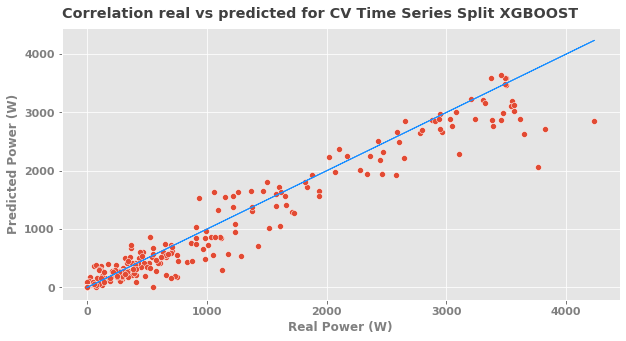

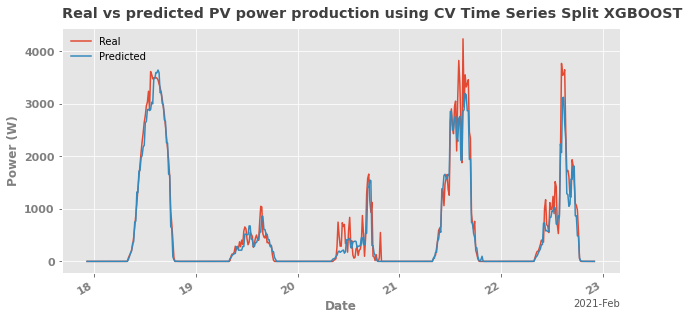

In [53]:
# Plots
result_plots(xgboost_cv, 'CV Time Series Split XGBOOST')

#### K Fold

In [54]:
%%time
kf = KFold(n_splits= 5, shuffle= True, random_state= 18)

xgboost_cv = pd.DataFrame()

for train_idx, val_idx in kf.split(df_cv):
    
    train_cv = df_cv.iloc[train_idx]
    test_cv = df_cv.iloc[val_idx]

    xtrain_cv = train_cv[FEATURE_COLUMNS]
    ytrain_cv = train_cv[FORECAST_COLUMN]

    xtest_cv = test_cv[FEATURE_COLUMNS]
    ytest_cv = test_cv[FORECAST_COLUMN]

    reg_XGBOOST_cv.fit(xtrain_cv, ytrain_cv, 
                    eval_set= [(xtrain_cv, ytrain_cv), (xtest_cv, ytest_cv)],
                    early_stopping_rounds= 50,
                    verbose= 100)

    ypred_cv = pd.DataFrame(reg_XGBOOST_cv.predict(xtest_cv), columns= ['Prediction'], index= xtest_cv.index)
    ypred_cv['Real'] = ytest_cv
    xgboost_cv = xgboost_cv.append(ypred_cv)

xgboost_cv['Prediction'] = np.where(xgboost_cv['Prediction'] < 0, 0 , xgboost_cv['Prediction'])
xgboost_cv['Prediction'] = np.where((xgboost_cv.index.hour < 6) | (xgboost_cv.index.hour > 19) , 0, xgboost_cv['Prediction'])

[0]	validation_0-rmse:1272.75619	validation_1-rmse:1283.68946
[100]	validation_0-rmse:553.92337	validation_1-rmse:560.68013
[200]	validation_0-rmse:350.13599	validation_1-rmse:360.25029
[300]	validation_0-rmse:304.64079	validation_1-rmse:319.37007
[400]	validation_0-rmse:291.42371	validation_1-rmse:310.31401
[500]	validation_0-rmse:284.55446	validation_1-rmse:307.01277
[600]	validation_0-rmse:279.18312	validation_1-rmse:305.03914
[700]	validation_0-rmse:274.74510	validation_1-rmse:303.61904
[800]	validation_0-rmse:271.07459	validation_1-rmse:302.60585
[900]	validation_0-rmse:267.37601	validation_1-rmse:301.63145
[999]	validation_0-rmse:263.66738	validation_1-rmse:300.50891
[0]	validation_0-rmse:1274.39148	validation_1-rmse:1277.24308
[100]	validation_0-rmse:555.31914	validation_1-rmse:560.25504
[200]	validation_0-rmse:351.58278	validation_1-rmse:357.87029
[300]	validation_0-rmse:306.37141	validation_1-rmse:314.65216
[400]	validation_0-rmse:293.39046	validation_1-rmse:304.54284
[500]	va

In [55]:
# Errors
MAE_CV, RMSE_CV, normRMSE_CV, R2_CV = compute_errors(xgboost_cv, max(ytest_cv.Power))

print(f'CV K-Fold XGBOOST - Mean Absolute Error (MAE): {MAE_CV:.2f} W')
print(f'CV K-Fold XGBOOST - Root Mean Square Error (RMSE): {RMSE_CV:.2f} W')
print(f'CV K-Fold XGBOOST - Normalized RMSE: {normRMSE_CV:.2f} %')
print(f'CV K-Fold XGBOOST - R square: {R2_CV:.2f}')

CV K-Fold XGBOOST - Mean Absolute Error (MAE): 137.72 W
CV K-Fold XGBOOST - Root Mean Square Error (RMSE): 298.32 W
CV K-Fold XGBOOST - Normalized RMSE: 6.78 %
CV K-Fold XGBOOST - R square: 0.92


In [56]:
# Reset the option view all rows
pd.reset_option('display.max_rows')